# Setup

In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import operator
from functools import reduce
from functools import partial

import time
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import scipy.io
import h5py

#################################################
#
# Utilities
#
#################################################
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# reading data
class MatReader(object):
    def __init__(self, file_path, to_torch=True, to_cuda=False, to_float=True):
        super(MatReader, self).__init__()

        self.to_torch = to_torch
        self.to_cuda = to_cuda
        self.to_float = to_float

        self.file_path = file_path

        self.data = None
        self.old_mat = None
        self._load_file()

    def _load_file(self):
        try:
            self.data = scipy.io.loadmat(self.file_path)
            self.old_mat = True
        except:
            self.data = h5py.File(self.file_path, 'r')
            self.old_mat = False

    def load_file(self, file_path):
        self.file_path = file_path
        self._load_file()

    def read_field(self, field):
        x = self.data[field]

        if not self.old_mat:
            x = x[()]
            x = np.transpose(x, axes=range(len(x.shape) - 1, -1, -1))

        if self.to_float:
            x = x.astype(np.float32)

        if self.to_torch:
            x = torch.from_numpy(x)

            if self.to_cuda:
                x = x.cuda()

        return x

    def set_cuda(self, to_cuda):
        self.to_cuda = to_cuda

    def set_torch(self, to_torch):
        self.to_torch = to_torch

    def set_float(self, to_float):
        self.to_float = to_float

# normalization, pointwise gaussian
class UnitGaussianNormalizer(object):
    def __init__(self, x, eps=0.00001):
        super(UnitGaussianNormalizer, self).__init__()

        # x could be in shape of ntrain*n or ntrain*T*n or ntrain*n*T
        self.mean = torch.mean(x, 0)
        self.std = torch.std(x, 0)
        self.eps = eps

    def encode(self, x):
        x = (x - self.mean) / (self.std + self.eps)
        return x

    def decode(self, x, sample_idx=None):
        if sample_idx is None:
            std = self.std + self.eps # n
            mean = self.mean
        else:
            if len(self.mean.shape) == len(sample_idx[0].shape):
                std = self.std[sample_idx] + self.eps  # batch*n
                mean = self.mean[sample_idx]
            if len(self.mean.shape) > len(sample_idx[0].shape):
                std = self.std[:,sample_idx]+ self.eps # T*batch*n
                mean = self.mean[:,sample_idx]

        # x is in shape of batch*n or T*batch*n
        x = (x * std) + mean
        return x

    def cuda(self):
        self.mean = self.mean.cuda()
        self.std = self.std.cuda()

    def cpu(self):
        self.mean = self.mean.cpu()
        self.std = self.std.cpu()

# normalization, Gaussian
class GaussianNormalizer(object):
    def __init__(self, x, eps=0.00001):
        super(GaussianNormalizer, self).__init__()

        self.mean = torch.mean(x)
        self.std = torch.std(x)
        self.eps = eps

    def encode(self, x):
        x = (x - self.mean) / (self.std + self.eps)
        return x

    def decode(self, x, sample_idx=None):
        x = (x * (self.std + self.eps)) + self.mean
        return x

    def cuda(self):
        self.mean = self.mean.cuda()
        self.std = self.std.cuda()

    def cpu(self):
        self.mean = self.mean.cpu()
        self.std = self.std.cpu()


# normalization, scaling by range
class RangeNormalizer(object):
    def __init__(self, x, low=0.0, high=1.0):
        super(RangeNormalizer, self).__init__()
        mymin = torch.min(x, 0)[0].view(-1)
        mymax = torch.max(x, 0)[0].view(-1)

        self.a = (high - low)/(mymax - mymin)
        self.b = -self.a*mymax + high

    def encode(self, x):
        s = x.size()
        x = x.view(s[0], -1)
        x = self.a*x + self.b
        x = x.view(s)
        return x

    def decode(self, x):
        s = x.size()
        x = x.view(s[0], -1)
        x = (x - self.b)/self.a
        x = x.view(s)
        return x

#loss function with rel/abs Lp loss
class LpLoss(object):
    def __init__(self, d=2, p=2, size_average=True, reduction=True):
        super(LpLoss, self).__init__()

        #Dimension and Lp-norm type are postive
        assert d > 0 and p > 0

        self.d = d
        self.p = p
        self.reduction = reduction
        self.size_average = size_average

    def abs(self, x, y):
        num_examples = x.size()[0]

        #Assume uniform mesh
        h = 1.0 / (x.size()[1] - 1.0)

        all_norms = (h**(self.d/self.p))*torch.norm(x.view(num_examples,-1) - y.view(num_examples,-1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(all_norms)
            else:
                return torch.sum(all_norms)

        return all_norms

    def rel(self, x, y):
        num_examples = x.size()[0]

        diff_norms = torch.norm(x.reshape(num_examples,-1) - y.reshape(num_examples,-1), self.p, 1)
        y_norms = torch.norm(y.reshape(num_examples,-1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(diff_norms/y_norms)
            else:
                return torch.sum(diff_norms/y_norms)

        return diff_norms/y_norms

    def __call__(self, x, y):
        return self.rel(x, y)

# Sobolev norm (HS norm)
# where we also compare the numerical derivatives between the output and target
class HsLoss(object):
    def __init__(self, d=2, p=2, k=1, a=None, group=False, size_average=True, reduction=True):
        super(HsLoss, self).__init__()

        #Dimension and Lp-norm type are postive
        assert d > 0 and p > 0

        self.d = d
        self.p = p
        self.k = k
        self.balanced = group
        self.reduction = reduction
        self.size_average = size_average

        if a == None:
            a = [1,] * k
        self.a = a

    def rel(self, x, y):
        num_examples = x.size()[0]
        diff_norms = torch.norm(x.reshape(num_examples,-1) - y.reshape(num_examples,-1), self.p, 1)
        y_norms = torch.norm(y.reshape(num_examples,-1), self.p, 1)
        if self.reduction:
            if self.size_average:
                return torch.mean(diff_norms/y_norms)
            else:
                return torch.sum(diff_norms/y_norms)
        return diff_norms/y_norms

    def __call__(self, x, y, a=None):
        nx = x.size()[1]
        ny = x.size()[2]
        k = self.k
        balanced = self.balanced
        a = self.a
        x = x.view(x.shape[0], nx, ny, -1)
        y = y.view(y.shape[0], nx, ny, -1)

        k_x = torch.cat((torch.arange(start=0, end=nx//2, step=1),torch.arange(start=-nx//2, end=0, step=1)), 0).reshape(nx,1).repeat(1,ny)
        k_y = torch.cat((torch.arange(start=0, end=ny//2, step=1),torch.arange(start=-ny//2, end=0, step=1)), 0).reshape(1,ny).repeat(nx,1)
        k_x = torch.abs(k_x).reshape(1,nx,ny,1).to(x.device)
        k_y = torch.abs(k_y).reshape(1,nx,ny,1).to(x.device)

        x = torch.fft.fftn(x, dim=[1, 2])
        y = torch.fft.fftn(y, dim=[1, 2])

        if balanced==False:
            weight = 1
            if k >= 1:
                weight += a[0]**2 * (k_x**2 + k_y**2)
            if k >= 2:
                weight += a[1]**2 * (k_x**4 + 2*k_x**2*k_y**2 + k_y**4)
            weight = torch.sqrt(weight)
            loss = self.rel(x*weight, y*weight)
        else:
            loss = self.rel(x, y)
            if k >= 1:
                weight = a[0] * torch.sqrt(k_x**2 + k_y**2)
                loss += self.rel(x*weight, y*weight)
            if k >= 2:
                weight = a[1] * torch.sqrt(k_x**4 + 2*k_x**2*k_y**2 + k_y**4)
                loss += self.rel(x*weight, y*weight)
            loss = loss / (k+1)

        return loss

# A simple feedforward neural network
class DenseNet(torch.nn.Module):
    def __init__(self, layers, nonlinearity, out_nonlinearity=None, normalize=False):
        super(DenseNet, self).__init__()

        self.n_layers = len(layers) - 1

        assert self.n_layers >= 1

        self.layers = nn.ModuleList()

        for j in range(self.n_layers):
            self.layers.append(nn.Linear(layers[j], layers[j+1]))

            if j != self.n_layers - 1:
                if normalize:
                    self.layers.append(nn.BatchNorm1d(layers[j+1]))

                self.layers.append(nonlinearity())

        if out_nonlinearity is not None:
            self.layers.append(out_nonlinearity())

    def forward(self, x):
        for _, l in enumerate(self.layers):
            x = l(x)

        return x


# print the number of parameters
def count_params(model):
    c = 0
    for p in list(model.parameters()):
        c += reduce(operator.mul, list(p.size()))
    return c

In [3]:
class SpectralConv3d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2, modes3):
        super(SpectralConv3d, self).__init__()

        """
        3D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2
        self.modes3 = modes3

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, dtype=torch.cfloat))
        self.weights3 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, dtype=torch.cfloat))
        self.weights4 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul3d(self, input, weights):
        # (batch, in_channel, x,y,t ), (in_channel, out_channel, x,y,t) -> (batch, out_channel, x,y,t)
        return torch.einsum("bixyz,ioxyz->boxyz", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfftn(x, dim=[-3,-2,-1])

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-3), x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2, :self.modes3] = \
            self.compl_mul3d(x_ft[:, :, :self.modes1, :self.modes2, :self.modes3], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2, :self.modes3] = \
            self.compl_mul3d(x_ft[:, :, -self.modes1:, :self.modes2, :self.modes3], self.weights2)
        out_ft[:, :, :self.modes1, -self.modes2:, :self.modes3] = \
            self.compl_mul3d(x_ft[:, :, :self.modes1, -self.modes2:, :self.modes3], self.weights3)
        out_ft[:, :, -self.modes1:, -self.modes2:, :self.modes3] = \
            self.compl_mul3d(x_ft[:, :, -self.modes1:, -self.modes2:, :self.modes3], self.weights4)

        #Return to physical space
        x = torch.fft.irfftn(out_ft, s=(x.size(-3), x.size(-2), x.size(-1)))
        return x

In [4]:
class FNO3d(nn.Module):
    def __init__(self, modes1, modes2, modes3, width):
        super(FNO3d, self).__init__()
        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        input: the solution of the first 10 timesteps + 3 locations (u(1, x, y), ..., u(10, x, y),  x, y, t). It's a constant function in time, except for the last index.
        input shape: (batchsize, x=64, y=64, t=40, c=13)
        output: the solution of the next 40 timesteps
        output shape: (batchsize, x=64, y=64, t=40, c=1)
        """
        self.modes1 = modes1
        self.modes2 = modes2
        self.modes3 = modes3
        self.width = width
        self.fc0 = nn.Linear(13, self.width)
        # input channel is 12: the solution of the first 10 timesteps + 3 locations (u(1, x, y), ..., u(10, x, y),  x, y, t)
        self.conv0 = SpectralConv3d(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.conv1 = SpectralConv3d(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.conv2 = SpectralConv3d(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.conv3 = SpectralConv3d(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.w0 = nn.Conv1d(self.width, self.width, 1)
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)
        self.w3 = nn.Conv1d(self.width, self.width, 1)
        self.bn0 = torch.nn.BatchNorm3d(self.width, track_running_stats=False)
        self.bn1 = torch.nn.BatchNorm3d(self.width, track_running_stats=False)
        self.bn2 = torch.nn.BatchNorm3d(self.width, track_running_stats=False)
        self.bn3 = torch.nn.BatchNorm3d(self.width, track_running_stats=False)
        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        batchsize = x.shape[0]
        size_x, size_y, size_z = x.shape[1], x.shape[2], x.shape[3]
        x = self.fc0(x)
        x = x.permute(0, 4, 1, 2, 3)
        x1 = self.conv0(x)
        x1 = self.bn0(x1)
        x2 = self.w0(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y, size_z)
        x = x1 + x2
        x = F.relu(x)
        x1 = self.conv1(x)
        x1 = self.bn1(x1)
        x2 = self.w1(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y, size_z)
        x = x1 + x2
        x = F.relu(x)
        x1 = self.conv2(x)
        # x1 = self.bn2(x1)
        x2 = self.w2(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y, size_z)
        x = x1 + x2
        x = F.relu(x)
        x1 = self.conv3(x)
        # x1 = self.bn3(x1)
        x2 = self.w3(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y, size_z)
        x = x1 + x2
        x = x.permute(0, 2, 3, 4, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

# Parameters

In [5]:
ntrain = 800
ntest = 200

sample_rate = 1
S = 64 // sample_rate

sample_rate_t = 1
T = 50 // sample_rate_t

T_in = 10

pad_size = 25

batch_size = 1
learning_rate = 0.001

epochs = 100
step_size = 15
gamma = 0.5

modes = 8
width = 20

# Load Data

In [7]:
data_loader = MatReader('data/ns_V1e-3_N5000_T50.mat')

x_data_raw = data_loader.read_field('u')[:,::sample_rate,::sample_rate,:T_in]
y_data_raw = data_loader.read_field('u')[:,::sample_rate,::sample_rate,T_in:]

print(x_data_raw.shape)
print(y_data_raw.shape)

x_train = x_data_raw[:ntrain]
y_train = y_data_raw[:ntrain]

x_test = x_data_raw[-ntest:]
y_test = y_data_raw[-ntest:]

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

del x_data_raw
del y_data_raw

torch.Size([5000, 64, 64, 10])
torch.Size([5000, 64, 64, 40])
torch.Size([800, 64, 64, 10])
torch.Size([800, 64, 64, 40])
torch.Size([200, 64, 64, 10])
torch.Size([200, 64, 64, 40])


In [8]:
x_normalizer = UnitGaussianNormalizer(x_train)
x_train = x_normalizer.encode(x_train)
x_test = x_normalizer.encode(x_test)

y_normalizer = UnitGaussianNormalizer(y_train)
y_train = y_normalizer.encode(y_train)
y_test = y_normalizer.encode(y_test)

x_train = x_train.reshape(ntrain, S, S, 1, T_in).repeat([1,1,1,T-T_in,1])
x_test = x_test.reshape(ntest, S, S, 1, T_in).repeat([1,1,1,T-T_in,1])

print(x_train.shape)
print(x_test.shape)

torch.Size([800, 64, 64, 40, 10])
torch.Size([200, 64, 64, 40, 10])


In [9]:
def pad2D(x_in_train, x_in_test, pad_size):
#     padx_train = torch.zeros((ntrain, pad_size, data_points, time_points, time_in))
#     x_train_pad = torch.cat([padx_train, x_train, padx_train], 1)
    
#     print(x_train_pad.shape)
    
#     pady_train = torch.zeros((ntrain, data_points + 2*pad_size, pad_size, time_points, time_in))
#     x_train_pad = torch.cat([pady_train, x_train_pad, pady_train], 2)
    
#     print(x_train_pad.shape)
    
#     padx_test = torch.zeros((ntest, pad_size, data_points, time_points, time_in))
#     x_test_pad = torch.cat([padx_test, x_test, padx_test], 1)
    
#     print(x_test_pad.shape)
    
#     pady_test = torch.zeros((ntest, data_points + 2*pad_size, pad_size, time_points, time_in))
#     x_test_pad = torch.cat([pady_test, x_test_pad, pady_test], 2)

    x_in_train = F.pad(x_in_train, (0, 0, 0, pad_size), mode = 'constant', value = 0)
    
    x_in_test = F.pad(x_in_test, (0, 0, 0, pad_size), mode = 'constant', value = 0)
    
#     print(x_in_train.shape)
#     print(x_in_test.shape)
    
    gridx_pad = torch.tensor(np.linspace(0,1,S), dtype = torch.float)
    gridx_pad = gridx_pad.reshape(1, S, 1, 1, 1).repeat([1, 1, S, T-T_in+pad_size, 1])
    
#     print(gridx_pad.shape)
    
    gridy_pad = torch.tensor(np.linspace(0, 1, S), dtype = torch.float)
    gridy_pad = gridy_pad.reshape(1, 1, S, 1, 1).repeat([1, S, 1, T-T_in+pad_size, 1])
    
#     print(gridy_pad.shape)
    
    gridt_pad = torch.tensor(np.linspace(0,(T-T_in+pad_size)/(T-T_in),T-T_in+pad_size), dtype = torch.float)
    gridt_pad = gridt_pad.reshape(1, 1, 1, T-T_in+pad_size, 1).repeat([1, S, S, 1, 1])
    
#     print(gridt_pad.shape)
    
    x_train_pad = torch.cat((gridx_pad.repeat([ntrain, 1, 1, 1, 1]), gridy_pad.repeat([ntrain,1,1,1,1]),
                                gridt_pad.repeat([ntrain,1,1,1,1]), x_in_train), dim = -1)
    
    x_test_pad = torch.cat((gridx_pad.repeat([ntest, 1, 1, 1, 1]), gridy_pad.repeat([ntest,1,1,1,1]),
                                gridt_pad.repeat([ntest,1,1,1,1]), x_in_test), dim = -1)
    
    print(x_train_pad.shape)
    print(x_test_pad.shape)
    
    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train_pad, y_train), batch_size = batch_size, shuffle = True)
    test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test_pad, y_test), batch_size = batch_size, shuffle = False)
    
    return train_loader, test_loader

In [10]:
train_loader, test_loader = pad2D(x_train, x_test, pad_size)

torch.Size([800, 64, 64, 65, 13])
torch.Size([200, 64, 64, 65, 13])


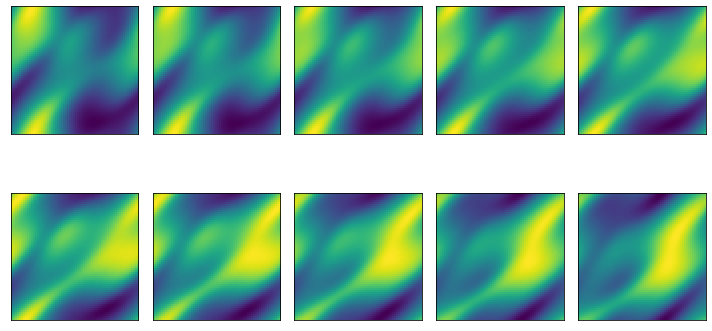

In [11]:
fig = plt.figure(figsize = (10,6))

iter_train = iter(train_loader)
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.xticks([],[])
    plt.yticks([],[])
    plt.imshow(y_test[0,:,:,i], interpolation = 'none')

plt.tight_layout()

# Neural Network

In [12]:
model = FNO3d(modes, modes, modes, width).cuda()
print(count_params(model))

optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay = 1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = step_size, gamma = gamma)

l2_loss = LpLoss(size_average = False)

3281737


In [13]:
def train(train_loader, model, optimizer, scheduler, l2_loss, epoch):
    model.train()
    start_time = time.perf_counter()
    total_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        
        output = model(data)
        
        # remove padding
        output = output.narrow(3, 0, T-T_in)
        
        # loss = F.mse_loss(output.view(batch_size,-1), target.view(batch_size,-1), reduction = 'sum')
        loss = l2_loss(output.view(batch_size, S, S, T-T_in), target.view(batch_size, S, S, T-T_in))

        total_loss += loss.item()

        loss.backward()

        optimizer.step()

    print('Train Epoch: {} Loss: {:.8E} Time: {:.1f}'.format(
        epoch,
        total_loss / len(train_loader.dataset),
        time.perf_counter() - start_time
    ))
    scheduler.step()


def test(test_loader, model, l2_loss):
    model.eval()
    loss = 0
    start_time = time.perf_counter()
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.cuda(), target.cuda()
            output = model(data)

            # remove padding
            output = output.narrow(3, 0, T-T_in)
            
            # loss += F.mse_loss(output.view(batch_size, -1), target.view(batch_size,-1), reduction = 'sum').item()
            loss += l2_loss(output.view(batch_size, S, S, T-T_in), target.view(batch_size, S, S, T-T_in)).item()
    
    runtime = time.perf_counter() - start_time
    loss /= len(test_loader.dataset)
    print('Test Loss: {:.8E} Time: {:.1f}'.format(
        loss,
        runtime
    ))

In [14]:
test(test_loader, model, l2_loss)
for epoch in range(1, epochs+1):
    train(train_loader, model, optimizer, scheduler, l2_loss, epoch)
    test(test_loader, model, l2_loss)

Test Loss: 1.00250023E+00 Time: 17.3
Train Epoch: 1 Loss: 2.75818353E-01 Time: 162.4
Test Loss: 2.13043303E-01 Time: 19.0
Train Epoch: 2 Loss: 1.62649775E-01 Time: 160.8
Test Loss: 1.43318577E-01 Time: 18.4
Train Epoch: 3 Loss: 1.39425121E-01 Time: 161.2
Test Loss: 1.47667072E-01 Time: 16.1
Train Epoch: 4 Loss: 1.28331970E-01 Time: 162.2
Test Loss: 1.26403394E-01 Time: 15.6
Train Epoch: 5 Loss: 1.19556869E-01 Time: 167.1
Test Loss: 1.16768047E-01 Time: 19.3
Train Epoch: 6 Loss: 1.16050346E-01 Time: 164.3
Test Loss: 1.14024165E-01 Time: 20.8
Train Epoch: 7 Loss: 1.10566604E-01 Time: 165.0
Test Loss: 1.10335898E-01 Time: 30.0
Train Epoch: 8 Loss: 1.09554050E-01 Time: 164.7
Test Loss: 1.09369283E-01 Time: 26.3


KeyboardInterrupt: 

# Data Analysis

In [ ]:
data, target = next(iter(test_loader))
data = data.cuda()
output = model(data)
print(output.shape)
output = output.cpu().detach().numpy()

output = output.reshape((S, S, T-T_in))
target = target.reshape((S, S, T-T_in))

fig = plt.figure(figsize = (6,10))

count = 1
for i in range(5):
    plt.subplot(5,2,count)
    plt.imshow(output[:,:,i], interpolation = 'none')
    plt.xticks([],[])
    plt.yticks([],[])
    
    count += 1
    
    plt.subplot(5,2, count)
    plt.imshow(target[:,:,i], interpolation = 'none')
    plt.xticks([],[])
    plt.yticks([],[])
    
    count += 1

plt.tight_layout()